In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Input space transformation (dimensionality reduction)
from sklearn.decomposition import PCA
from sklearn import random_projection
from sklearn import cluster
from sklearn.random_projection import johnson_lindenstrauss_min_dim

import utils

from clustering_adv_sample_detection import ClusterAdversarialClassifier as Classifier

## Testing Cluster Adversarial Classifier

### Load Data

In [2]:
# MNIST
X_train, y_train, X_test, y_test = utils.load_mnist()

# Perfomance on MNIST with PCA transform, FC NN, and eps=3e-2: 
# Wall time: 1min 33s
# Cluster Classifier Accuracy on clean data: 97.930
# Cluster Classifier Accuracy on adversarial data: 92.460
# Percentage of input data flagged as suspicious by detector: 45.670

# Fashion MNIST
#X_train, y_train, X_test, y_test = utils.load_fashion_mnist()

# Perfomance on Fashion MNIST with PCA transform, FC NN, and eps=3e-2: 
# Wall time: 2min
# Cluster Classifier Accuracy on clean data: 87.760
# Cluster Classifier Accuracy on adversarial data: 79.280
# Percentage of input data flagged as suspicious by detector: 46.340

# CIFAR-10
#X_train, y_train, X_test, y_test = utils.load_cifar10()

# Perfomance on CIFAR-10 with PCA transform, FC NN, and eps=3e-2:  
# Wall time: 8min 28s
# Cluster Classifier Accuracy on clean data: 51.990
# Cluster Classifier Accuracy on adversarial data: 43.500
# Percentage of input data flagged as suspicious by detector: 55.520

### Create Black Box Attack

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0 - Training loss: 0.22307320464985012
Epoch 1 - Training loss: 0.13005157091743202
Epoch 2 - Training loss: 0.09155069943727852
Epoch 3 - Training loss: 0.08616545239725996
Epoch 4 - Training loss: 0.04577650302203129

Training Time (in minutes) = 2.566085124015808
Predicted Digit = 5
Number Of Images Tested = 10000

Model Accuracy = 0.984


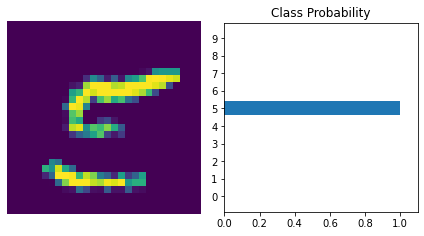

In [3]:
from model import My_VGG as Model

black_box_model = Model(in_channels=1, in_size=28, num_classes=10)
black_box_model = utils.train_model(black_box_model, X_train, X_test, y_train, y_test, epochs=5)

eps = 1.5e-1

# eps = 1e-1:
# Black box attack accuracy: 87.8%, with 98.82% accuracy on clean data
# Cluster Classifier Accuracy on adversarial data: 90.890
# Percentage of input data flagged as suspicious by detector: 18.430
# Cluster Classifier Accuracy on clean and adversarial data: 94.405
# Percentage of input data flagged as suspicious by detector: 10.345
# Baseline classifier on clean and adversarial data: Model Accuracy = 0.98585

# eps = 1.5e-1
# Black box attack accuracy: 66.64%, with 98.27% accuracy on clean data
# Cluster Classifier Accuracy on adversarial data: 84.210
# Percentage of input data flagged as suspicious by detector: 51.770
# Cluster Classifier Accuracy on clean and adversarial data: 91.240
# Percentage of input data flagged as suspicious by detector: 29.180
# Baseline classifier on clean test data: 0.9877
# Baseline classifier on adversarial test data: 0.9814
# Baseline classifier on clean and adversarial data: 0.98455

# eps = 2e-1
# Black box attack accuracy: 39.95%, with 99.05% accuracy on clean data
# Cluster Classifier Accuracy on clean data: 98.240
# Cluster Classifier Accuracy on adversarial data: 79.300
# Percentage of input data flagged as suspicious by detector: 65.910
# Cluster Classifier Accuracy on clean and adversarial data: 88.770
# Percentage of input data flagged as suspicious by detector: 34.545
# Baseline classifier on clean test data: Model Accuracy = 0.9894
# Baseline classifier on adversarial test data: Model Accuracy = 0.9432
# Baseline classifier on clean and adversarial data: 0.9663

# eps = 3e-1
# Black box attack accuracy: 31.38%, with 98.95% accuracy on clean data
# Cluster Classifier Accuracy on clean data: 98.090
# Cluster Classifier Accuracy on adversarial data: 64.980
# Percentage of input data flagged as suspicious by detector: 58.230
# Cluster Classifier Accuracy on clean and adversarial data: 81.535
# Percentage of input data flagged as suspicious by detector: 30.230
# Baseline classifier on clean test data: Model Accuracy = 0.9873
# Baseline classifier on adversarial test data: Model Accuracy = 0.9651
# Baseline classifier on clean and adversarial data: Model Accuracy = 0.9762

test_dataloader = utils.create_dataloader(X_test, y_test)
adv_test_data = utils.add_adversarial_noise(black_box_model, test_dataloader, eps=eps)

### Train Base Neural Network For Clustering Detector/Classifier

In [4]:
model = Model(in_channels=1, in_size=28, num_classes=10)

Epoch 0 - Training loss: 0.2274831569159596
Epoch 1 - Training loss: 0.11999090649306866
Epoch 2 - Training loss: 0.11273760746043875
Epoch 3 - Training loss: 0.10737284313233401
Epoch 4 - Training loss: 0.043009846211224986

Training Time (in minutes) = 2.4158006350199384
Predicted Digit = 8
Number Of Images Tested = 10000

Model Accuracy = 0.9908


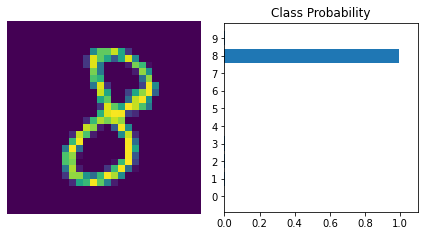

In [5]:
# Now let's start training the network
# input_size = X_train.shape[1]
# hidden_sizes = [128, 64]
# output_size = 10

# model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
#                       nn.ReLU(),
#                       nn.Linear(hidden_sizes[0], hidden_sizes[1]),
#                       nn.ReLU(),
#                       nn.Linear(hidden_sizes[1], output_size),
#                       nn.LogSoftmax(dim=1))

model = utils.train_model(model, X_train, X_test, y_train, y_test, epochs=5)

### Testing base model on adversarial data

In [6]:
# White box: 66.64%, with about 99% accuracy on clean data

# Model accuracy on adversarial data
utils.eval_model(model, adv_test_data, y_test)

Number Of Samples Tested = 10000

Model Accuracy = 0.6664


### Input Space (Dimensionality Reduction) Transforms - optional

In [7]:
# SKLearn method for determining a "minimum" number of components to reduce the dataset to
n_comp = johnson_lindenstrauss_min_dim(X_train.shape[0], eps=.99)

# Control (no transform): Wall time: 2min 53s, clean: 0.9733, adv: 0.8829
#transformer = None

# GaussianRandomProjection(n_components=374): Wall time: 1min 47s, clean: 0.9737, adv: 0.8892
# 2nd run: Wall time: 1min 52s, clean: 0.9727, adv: 0.911
#transformer = random_projection.GaussianRandomProjection(n_components=n_comp)

# SparseRandomProjection(n_components=374): Wall time: 1min 46s, clean: 0.9744, adv: 0.9247
# 2nd run: Wall time: 1min 47s, clean: 0.9706, adv: 0.8998
#transformer = random_projection.SparseRandomProjection(n_components=n_comp)

# PCA(n_components=374): Wall time: 1min 53s, clean: 0.9783, adv: 0.9137
# 2nd run: Wall time: 1min 32s, clean: 0.9757, adv: 0.9028
transformer = PCA(n_components=n_comp)

# FeatureAgglomeration(n_clusters=10):  Wall time: 46.2 s, clean: 0.8512, adv: 0.782
#transformer = cluster.FeatureAgglomeration(n_clusters=10)

### Fitting and scoring the classifier on clean data

In [8]:
classifier = Classifier(model, transformer)

%time classifier.fit(X_train, y_train)
print("Cluster Classifier Accuracy on clean data: %.3f" % (classifier.score(X_test, y_test) * 100.0))

Wall time: 2min 11s
Cluster Classifier Accuracy on clean data: 98.270


### Scoring the classifier on clean and adversarial data

In [9]:
test_data = np.concatenate((X_test, adv_test_data), axis=0)
test_labels = np.concatenate((y_test, y_test), axis=0)

In [10]:
print("Cluster Classifier Accuracy on adversarial data: %.3f" % (classifier.score(adv_test_data, y_test) * 100.0))
print("Percentage of input data flagged as suspicious by detector: %.3f" % (classifier.proportion_flagged * 100))

Cluster Classifier Accuracy on adversarial data: 84.210
Percentage of input data flagged as suspicious by detector: 51.770


In [11]:
print("Cluster Classifier Accuracy on clean and adversarial data: %.3f" % (classifier.score(test_data, test_labels) * 100.0))
print("Percentage of input data flagged as suspicious by detector: %.3f" % (classifier.proportion_flagged * 100))

Cluster Classifier Accuracy on clean and adversarial data: 91.240
Percentage of input data flagged as suspicious by detector: 29.180


## Baseline Method - Adversarial Training

### Generate adversarial data

In [12]:
train_dataloader = utils.create_dataloader(X_train, y_train)
adv_train_data = utils.add_adversarial_noise(model, train_dataloader, eps=eps)

In [13]:
baseline_train_data = np.concatenate((X_train, adv_train_data), axis=0)
baseline_train_labels = np.concatenate((y_train, y_train), axis=0)

### Train model with mix of clean and adversarial data

In [14]:
baseline_model = Model(in_channels=1, num_classes=10)

Epoch 0 - Training loss: 0.1901251179168001
Epoch 1 - Training loss: 0.10545352195819238
Epoch 2 - Training loss: 0.06134186080237947
Epoch 3 - Training loss: 0.04522932083931816
Epoch 4 - Training loss: 0.029714609814513

Training Time (in minutes) = 4.98698388338089
Predicted Digit = 4
Number Of Images Tested = 20000

Model Accuracy = 0.98455


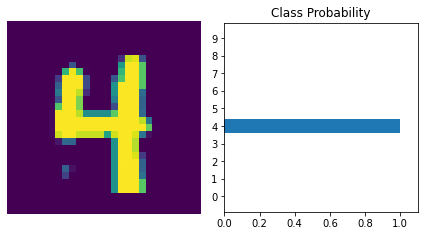

In [15]:
baseline_model = utils.train_model(baseline_model, baseline_train_data, test_data, baseline_train_labels, test_labels, epochs=5)

In [16]:
print("Baseline classifier on clean test data: ")
utils.eval_model(baseline_model, X_test, y_test)
print("Baseline classifier on adversarial test data: ")
utils.eval_model(baseline_model, adv_test_data, y_test)

Baseline classifier on clean test data: 
Number Of Samples Tested = 10000

Model Accuracy = 0.9877
Baseline classifier on adversarial test data: 
Number Of Samples Tested = 10000

Model Accuracy = 0.9814


In [17]:
print("Baseline classifier on clean and adversarial data: ")
utils.eval_model(baseline_model, test_data, test_labels)

Baseline classifier on clean and adversarial data: 
Number Of Samples Tested = 20000

Model Accuracy = 0.98455
